In [1]:
import sys
sys.path.insert(1, '../')
print(sys.path)

['/home/cboned/Projects/Koopman-Learning/notebooks', '../', '/home/cboned/miniconda3/envs/graphocr/lib/python310.zip', '/home/cboned/miniconda3/envs/graphocr/lib/python3.10', '/home/cboned/miniconda3/envs/graphocr/lib/python3.10/lib-dynload', '', '/home/cboned/miniconda3/envs/graphocr/lib/python3.10/site-packages']


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from collections import defaultdict
from datasets import Collator

import os

from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader

from transformers import ViTForImageClassification,  CLIPModel, ViTModel, ViTImageProcessor, AutoModel, AutoModelForImageClassification, Dinov2ForImageClassification, AutoImageProcessor
from models.ode_transformer_gpt  import ViTNeuralODE
import numpy as np
import scienceplots

from torchdiffeq import odeint
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE

from PIL import Image


cuda


In [3]:
# Set Matplotlib style
plt.style.use("science")
plt.rcParams['text.usetex'] = False

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 13,
        "legend.fontsize": 11,
        "figure.dpi": 300,
    }
)

# Dataset

In [4]:
DATASET_PATH = "/data/users/cboned/cifar"
train_dataset = CIFAR100(root=DATASET_PATH, download=False, train=True) ## Modify to Cifar100
validation_dataset = CIFAR100(root=DATASET_PATH, download=False, train=False)

In [5]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-with-registers-large')
collator = Collator(processor)

train_dloader = DataLoader(train_dataset, 
                           shuffle=False,
                           batch_size=1,
                           pin_memory=False,
                           num_workers=1,
                           collate_fn=collator.classification_collate_fn
                           )


test_dloader = DataLoader(validation_dataset,
                          batch_size=1,
                          pin_memory=False,
                          num_workers=1,
                          drop_last=True,
                          shuffle=True,
                          collate_fn=collator.classification_collate_fn

)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
class_name_cif10 = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}
class_name_cif100  = {
    0: 'beaver',
    1: 'dolphin',
    2: 'otter',
    3: 'seal',
    4: 'whale',
    5: 'aquarium fish',
    6: 'flatfish',
    7: 'ray',
    8: 'shark',
    9: 'trout',
    10: 'orchids',
    11: 'poppies',
    12: 'roses',
    13: 'sunflowers',
    14: 'tulips',
    15: 'bottles',
    16: 'bowls',
    17: 'cans',
    18: 'cups',
    19: 'plates',
    20: 'apples',
    21: 'mushrooms',
    22: 'oranges',
    23: 'pears',
    24: 'sweet peppers',
    25: 'clock',
    26: 'computer keyboard',
    27: 'lamp',
    28: 'telephone',
    29: 'television',
    30: 'bed',
    31: 'chair',
    32: 'couch',
    33: 'table',
    34: 'wardrobe',
    35: 'bee',
    36: 'beetle',
    37: 'butterfly',
    38: 'caterpillar',
    39: 'cockroach',
    40: 'bear',
    41: 'leopard',
    42: 'lion',
    43: 'tiger',
    44: 'wolf',
    45: 'bridge',
    46: 'castle',
    47: 'house',
    48: 'road',
    49: 'skyscraper',
    50: 'cloud',
    51: 'forest',
    52: 'mountain',
    53: 'plain',
    54: 'sea',
    55: 'camel',
    56: 'cattle',
    57: 'chimpanzee',
    58: 'elephant',
    59: 'kangaroo',
    60: 'fox',
    61: 'porcupine',
    62: 'possum',
    63: 'raccoon',
    64: 'skunk',
    65: 'crab',
    66: 'lobster',
    67: 'snail',
    68: 'spider',
    69: 'worm',
    70: 'baby',
    71: 'boy',
    72: 'girl',
    73: 'man',
    74: 'woman',
    75: 'crocodile',
    76: 'dinosaur',
    77: 'lizard',
    78: 'snake',
    79: 'turtle',
    80: 'hamster',
    81: 'mouse',
    82: 'rabbit',
    83: 'shrew',
    84: 'squirrel',
    85: 'maple',
    86: 'oak',
    87: 'palm',
    88: 'pine',
    89: 'willow',
    90: 'bicycle',
    91: 'bus',
    92: 'motorcycle',
    93: 'pickup truck',
    94: 'train',
    95: 'lawn-mower',
    96: 'rocket',
    97: 'streetcar',
    98: 'tank',
    99: 'tractor'
}

# Model

In [7]:
from transformers import Dinov2WithRegistersForImageClassification


teacher_model_checkpoint = "../checkpoints/Vit_CIFAR10_DINO.pt" #
model = ViTForImageClassification.from_pretrained(teacher_model_checkpoint, attn_implementation='eager').to(device)
#processor = AutoImageProcessor.from_pretrained("facebook/dinov2-with-registers-base")
#model = Dinov2WithRegistersForImageClassification.from_pretrained("facebook/dinov2-with-registers-base", attn_implementation='eager').to(device)
#model = ViTModel.from_pretrained("facebook/dino-vitb16")
model = model.eval()
#model.set_attn_implementation('eager')



In [8]:
EDO_CHECKPOINT_PATH = "/data/users/cboned/checkpoints/EDO_DISTILLATION_VIT_ON_CIFAR10_DINO_ATTENTION_L1_LOSS_FULL_PATH.pt"

edo_model = ViTNeuralODE(
    img_size=224,
    patch_size=16,
    in_chans=3,
    mlp_ratio=4,
    num_classes=10,
    embed_dim=768,
    num_heads=12,
    emulate_depth=12.0,
    time_interval=1.0,   # match 12 "layers" by integrating over [0,12]
    num_eval_steps=24,
    solver="euler",
    register_tokens=10,
    pos_embed_register_tokens=False
)




try:
    edo_model.load_state_dict(torch.load(EDO_CHECKPOINT_PATH, weights_only=True)["state_dict"])
except Exception as e:
    print(e)
    print("Matching individual Weights")
    weight_to_update = torch.load(EDO_CHECKPOINT_PATH, weights_only=True)
    for w in weight_to_update.keys():
        if edo_model.state_dict().get(w) is not None:
            edo_model.state_dict()[w].data.copy_(weight_to_update[w])

                
edo_model = edo_model.to(device)
edo_model = edo_model.eval()

In [9]:
for p in model.parameters():
        p.requires_grad = False
        
model.eval()
model = model.to(device)

## Example of Execution

In [35]:
data = next(iter(test_dloader))

inputs = data["pixel_values"].to(device)
original_image = data["raw_images"][0]
original_image_resized = original_image.resize((224, 224), resample=Image.BICUBIC)
with torch.no_grad():
    outputs = model(inputs["pixel_values"], output_attentions=True, output_hidden_states=True)
    outputs_edo = edo_model(inputs["pixel_values"], output_attentions=True, output_hidden_states=True, output_attention_trajectory=True)

In [36]:
patch_size= 16
# make the image divisible by the patch size
w = h = original_image_resized.size[1] % patch_size

w_featmap = original_image_resized.size[-2] // patch_size
h_featmap = original_image_resized.size[-1] // patch_size

In [37]:
print(w_featmap, h_featmap)

14 14


In [38]:
torch.nn.functional.softmax(outputs_edo["logits"], dim=-1).max(-1)

torch.return_types.max(
values=tensor([0.9958], device='cuda:0'),
indices=tensor([6], device='cuda:0'))

In [39]:
data["labels"]

tensor([26])

In [40]:
torch.stack(outputs.hidden_states, dim=0).shape

torch.Size([13, 1, 197, 768])

In [41]:
outputs.keys()

odict_keys(['logits', 'hidden_states', 'attentions'])

In [42]:
outputs_edo.keys()

dict_keys(['logits', 'second_derivative_upper_bound', 'finite_difference_upper_bound', 'attention_trajectory', 'attentions', 'attentions_register_tokens', 'jasmin_loss', 'states'])

In [70]:
attentions = outputs_edo["attentions"]
#attentions = outputs_edo["attentions_register_tokens"]
#attentions = outputs["attentions"]
attentions = torch.stack(attentions, dim=0)[-1] if isinstance(attentions, tuple) or isinstance(attentions, list) else attentions


In [71]:
# Getting the attentions
#attentions = torch.stack(outputs.attentions, dim=0)
nh = attentions.shape[1] # number of head
print(attentions.shape)
attentions = attentions[-1, :, 0, 1:w_featmap*h_featmap+1].reshape(nh, -1)
attentions.shape


torch.Size([1, 12, 197, 197])


torch.Size([12, 196])

In [72]:
attentions.shape

torch.Size([12, 196])

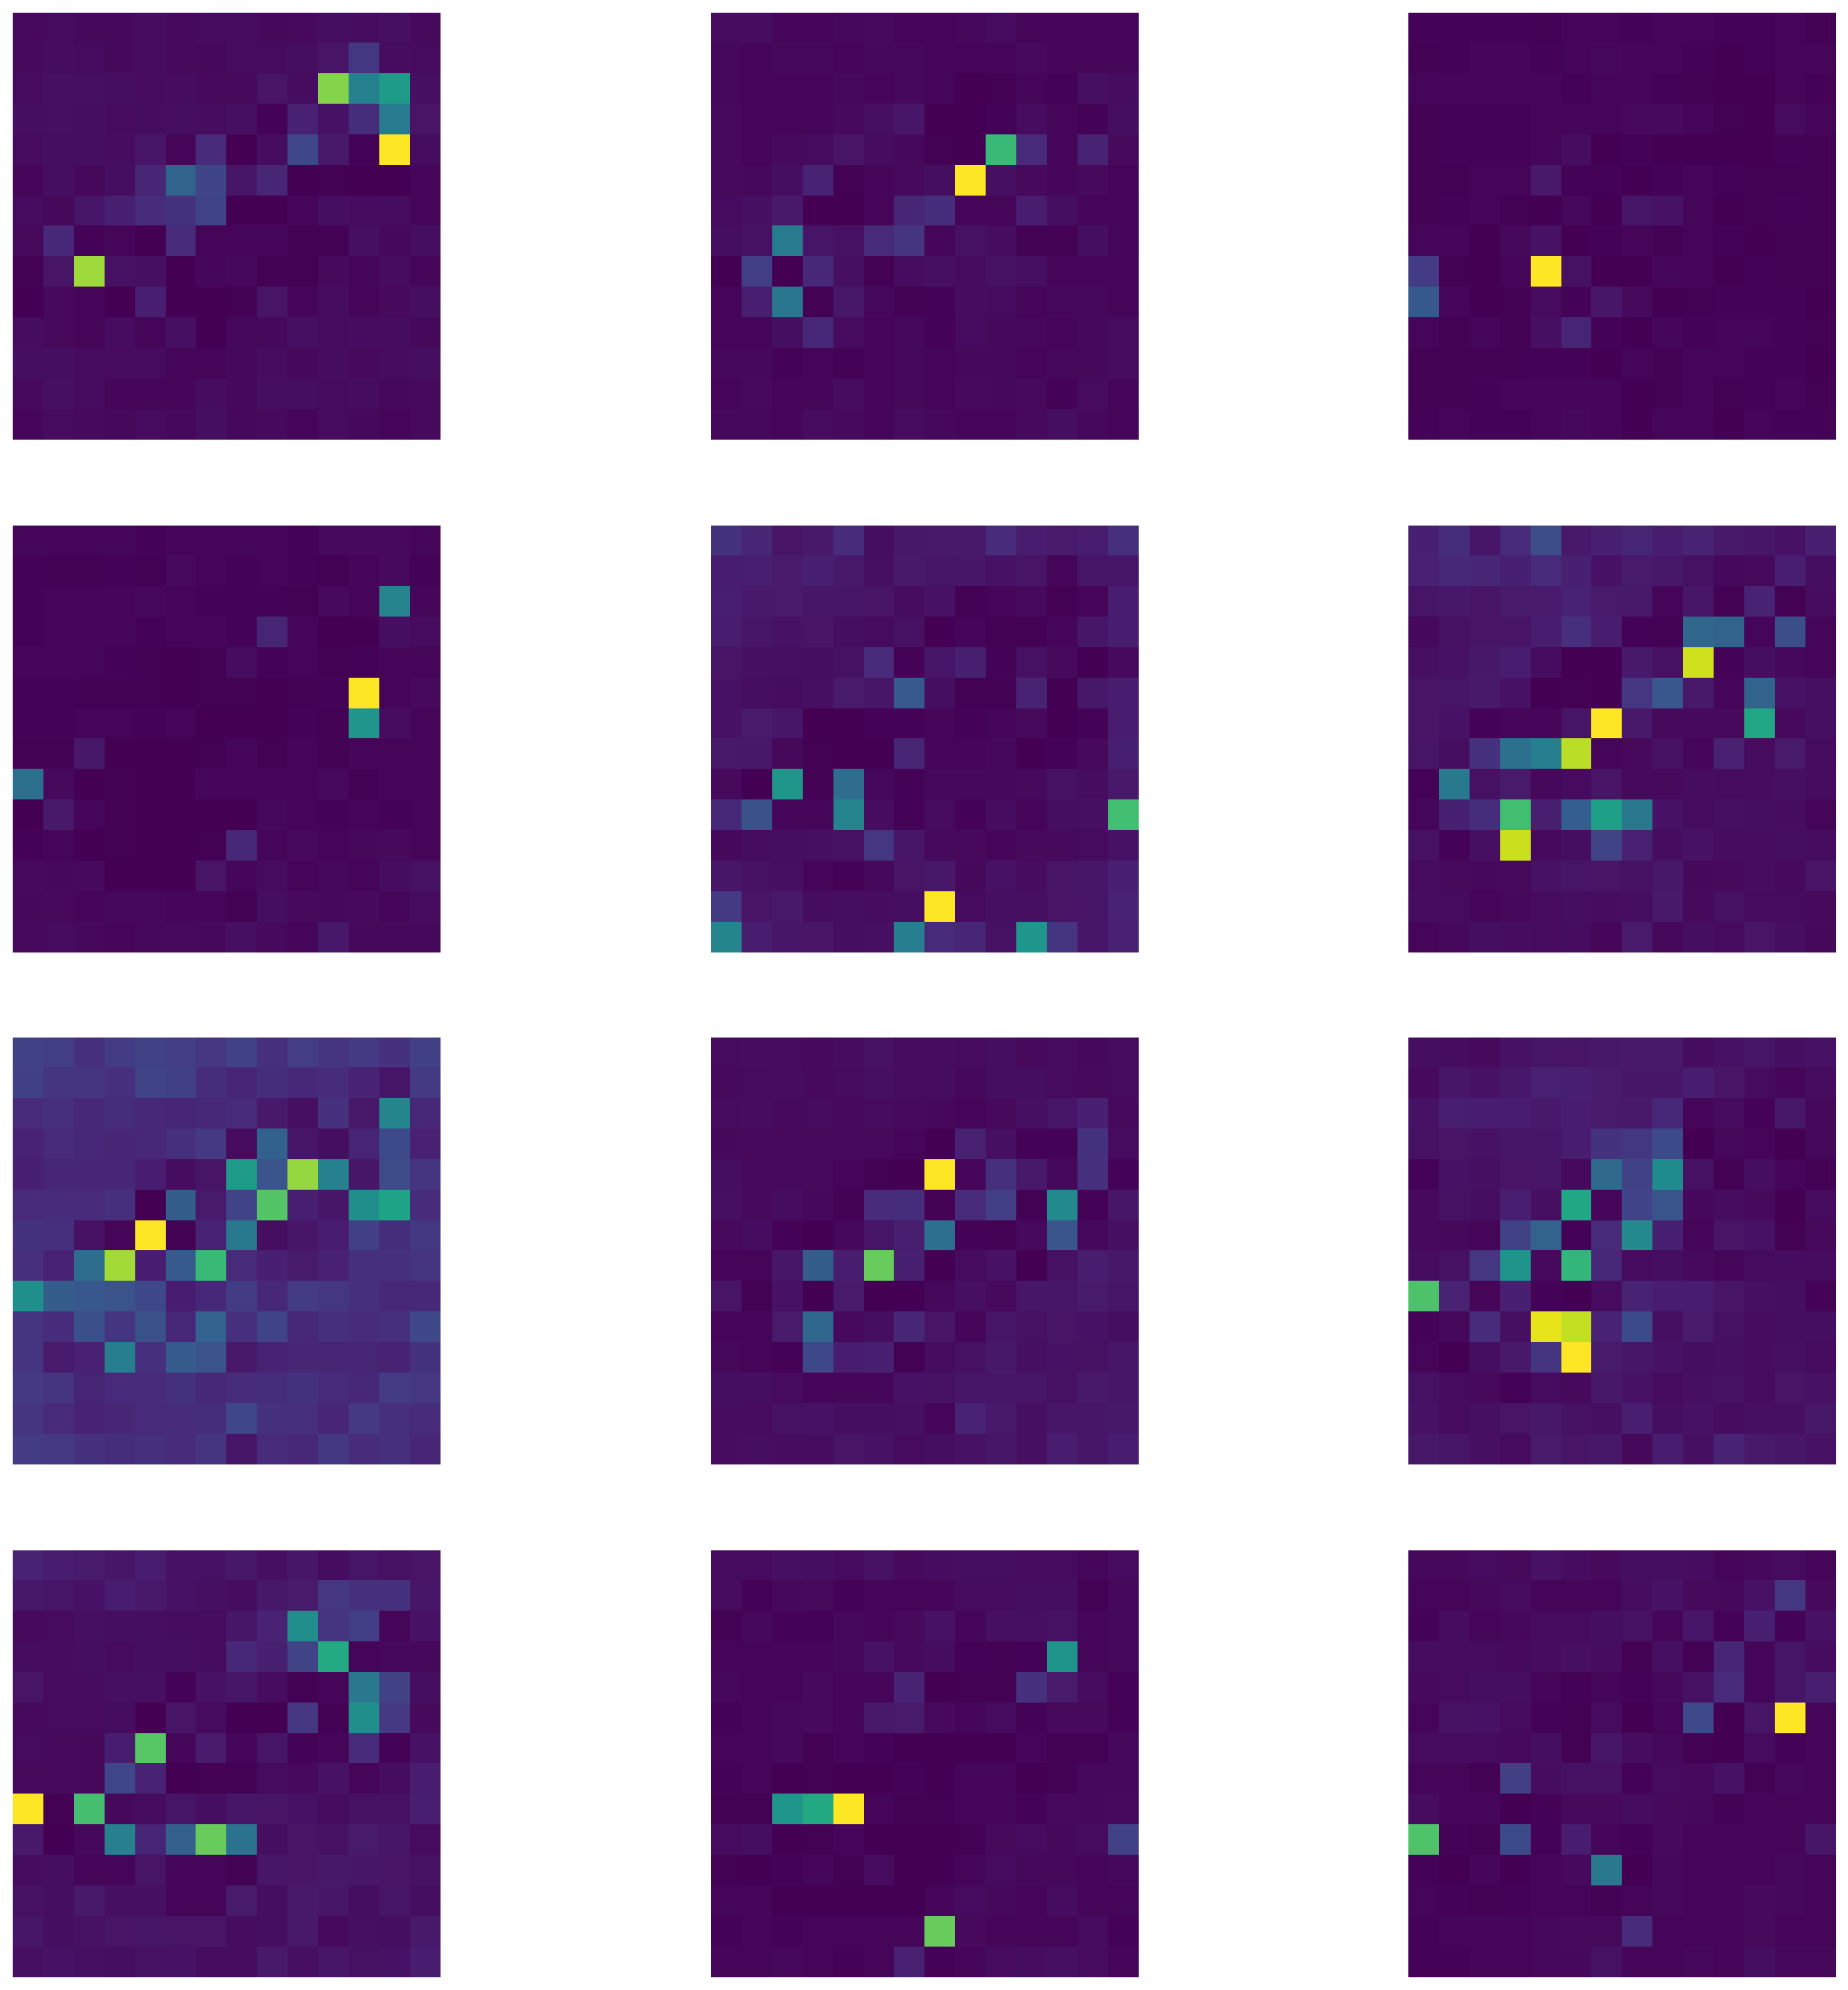

In [73]:
ig, axs = plt.subplots(4, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    plotting = attentions.reshape(nh, w_featmap, h_featmap)
    ax.imshow(plotting[i].cpu().numpy())
    ax.axis('off')

In [74]:
print(outputs_edo["states"].shape)

torch.Size([24, 1, 207, 768])


(-0.5, 223.5, 223.5, -0.5)

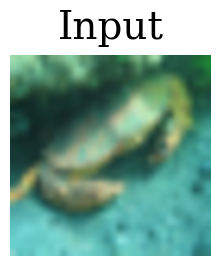

In [75]:
plt.figure(figsize=(6,6), dpi=200)
plt.subplot(4,4,1)
plt.title("Input")
plt.imshow(original_image_resized)
plt.axis("off")
# visualize self-attention of each head

(197,)
60.966404


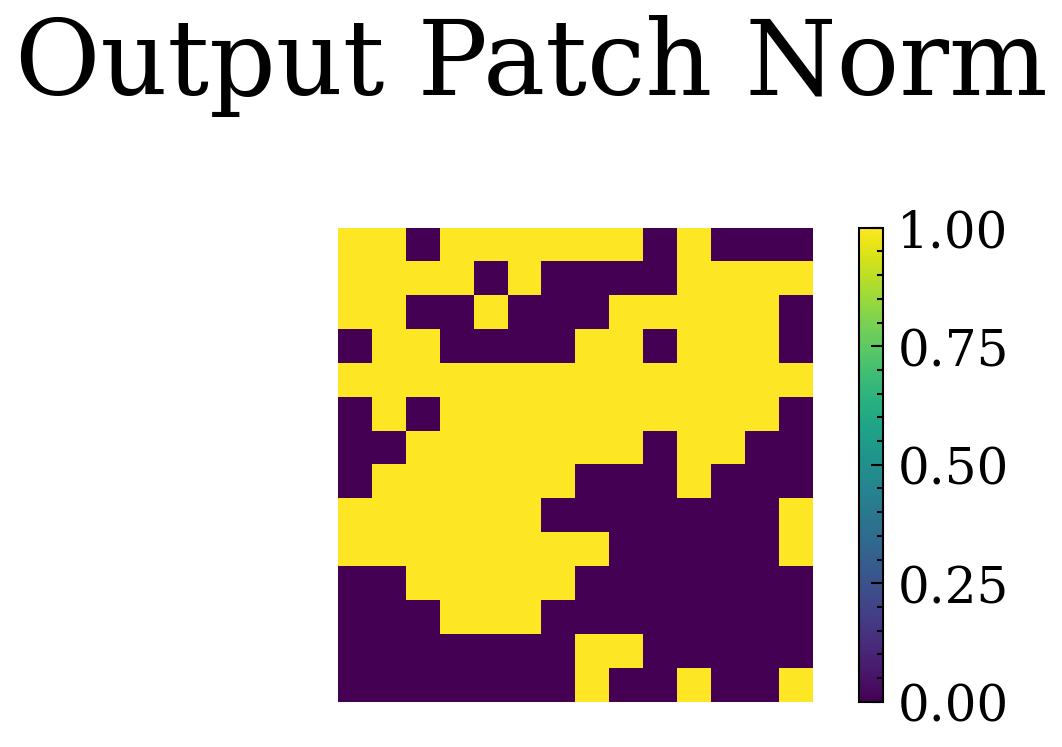

In [76]:


patch_norms = torch.norm(outputs["hidden_states"][-1].float().squeeze(0), dim=-1).detach().cpu().numpy()

print(patch_norms.shape)
print(patch_norms.mean())

patch_norms = patch_norms >= patch_norms.mean()

plt.axis('off')
plt.suptitle("Output Patch Norm", fontsize=25)

im = plt.imshow(patch_norms[1:w_featmap*h_featmap+1].reshape(w_featmap,w_featmap))
plt.colorbar(im)

plt.tight_layout()
plt.show()

In [77]:
from torchvision.transforms.functional import gaussian_blur

def extract_mass(attentions_last_head, threshold=0.8, patch_size:int=16, smooth=True, scale_factor=40):
    B, nh, num_patches = attentions_last_head.shape
    h_featmap = w_featmap = int(num_patches ** 0.5 + 0.5)

    val, idx = torch.sort(attentions_last_head, dim=-1)
    val = val / (val.sum(dim=(-1), keepdim=True) + 1e-8)
    cumval = torch.cumsum(val, dim=-1)

    if smooth:
        mask_soft = torch.sigmoid((cumval - (1 - threshold)) * scale_factor)
    else:
        mask_soft = (cumval > (1 - threshold)).float()

    idx2 = torch.argsort(idx, dim=-1)
    th_attn = torch.gather(mask_soft, dim=-1, index=idx2)

    th_attn = th_attn.view(B, nh, w_featmap, h_featmap).float()
    #th_attn = F.interpolate(th_attn, scale_factor=patch_size, mode="nearest")

    attn_reshaped = attentions_last_head.view(B, nh, w_featmap, h_featmap)
    #attn_interpolated = F.interpolate(attn_reshaped, scale_factor=patch_size, mode="nearest")

    attn_filtered = attn_reshaped * th_attn
    if smooth:
        attn_filtered = gaussian_blur(attn_filtered, kernel_size=(3,3), sigma=0.5)

    attentions_mean = attn_filtered.mean(dim=1)
    return attentions_mean, attn_filtered


torch.Size([1, 14, 14])
tensor(0.9636, device='cuda:0')


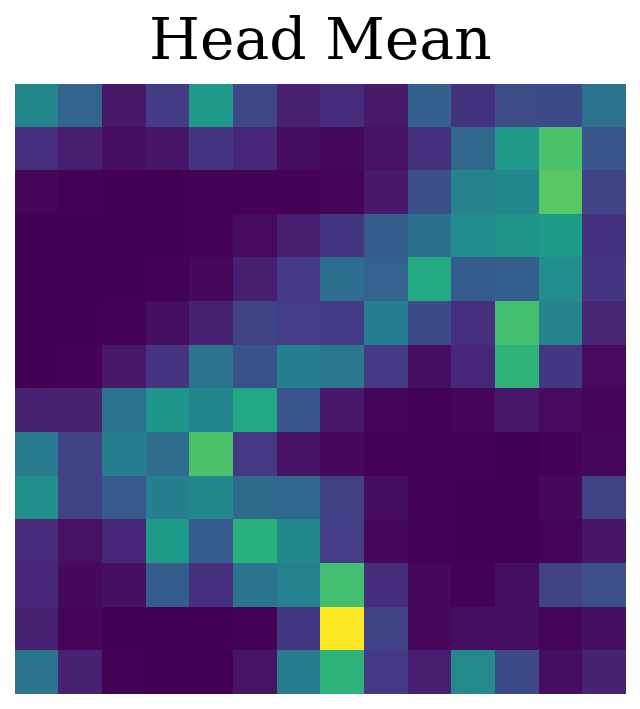

In [78]:
attentions_last_head = attentions
pl, attn_filt = extract_mass(attentions_last_head.unsqueeze(0), threshold=0.5, smooth=True, patch_size=16, scale_factor=40)
s_attn_mean = pl
attn_s = torch.log(s_attn_mean + 1e-8) # [B, N]
attn_s = F.log_softmax(attn_s / 1, dim=-1)
p_s = attn_s.exp().clamp(min=1e-8, max=1.0)
p_s = F.normalize(p_s, p=2, dim=-1)
print(p_s.shape)

print(p_s.max())
plt.title("Head Mean")
plt.imshow(p_s[0].detach().cpu().numpy())
plt.axis("off")
plt.tight_layout()

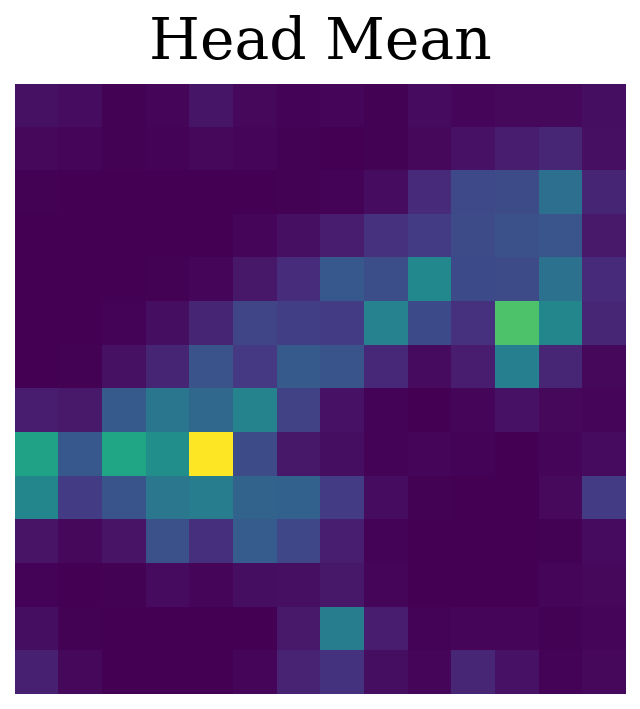

In [79]:
plt.title("Head Mean")
plt.imshow(pl[0].detach().cpu().numpy())
plt.axis("off")
plt.tight_layout()

In [54]:
pl.max()

tensor(0.0158, device='cuda:0')

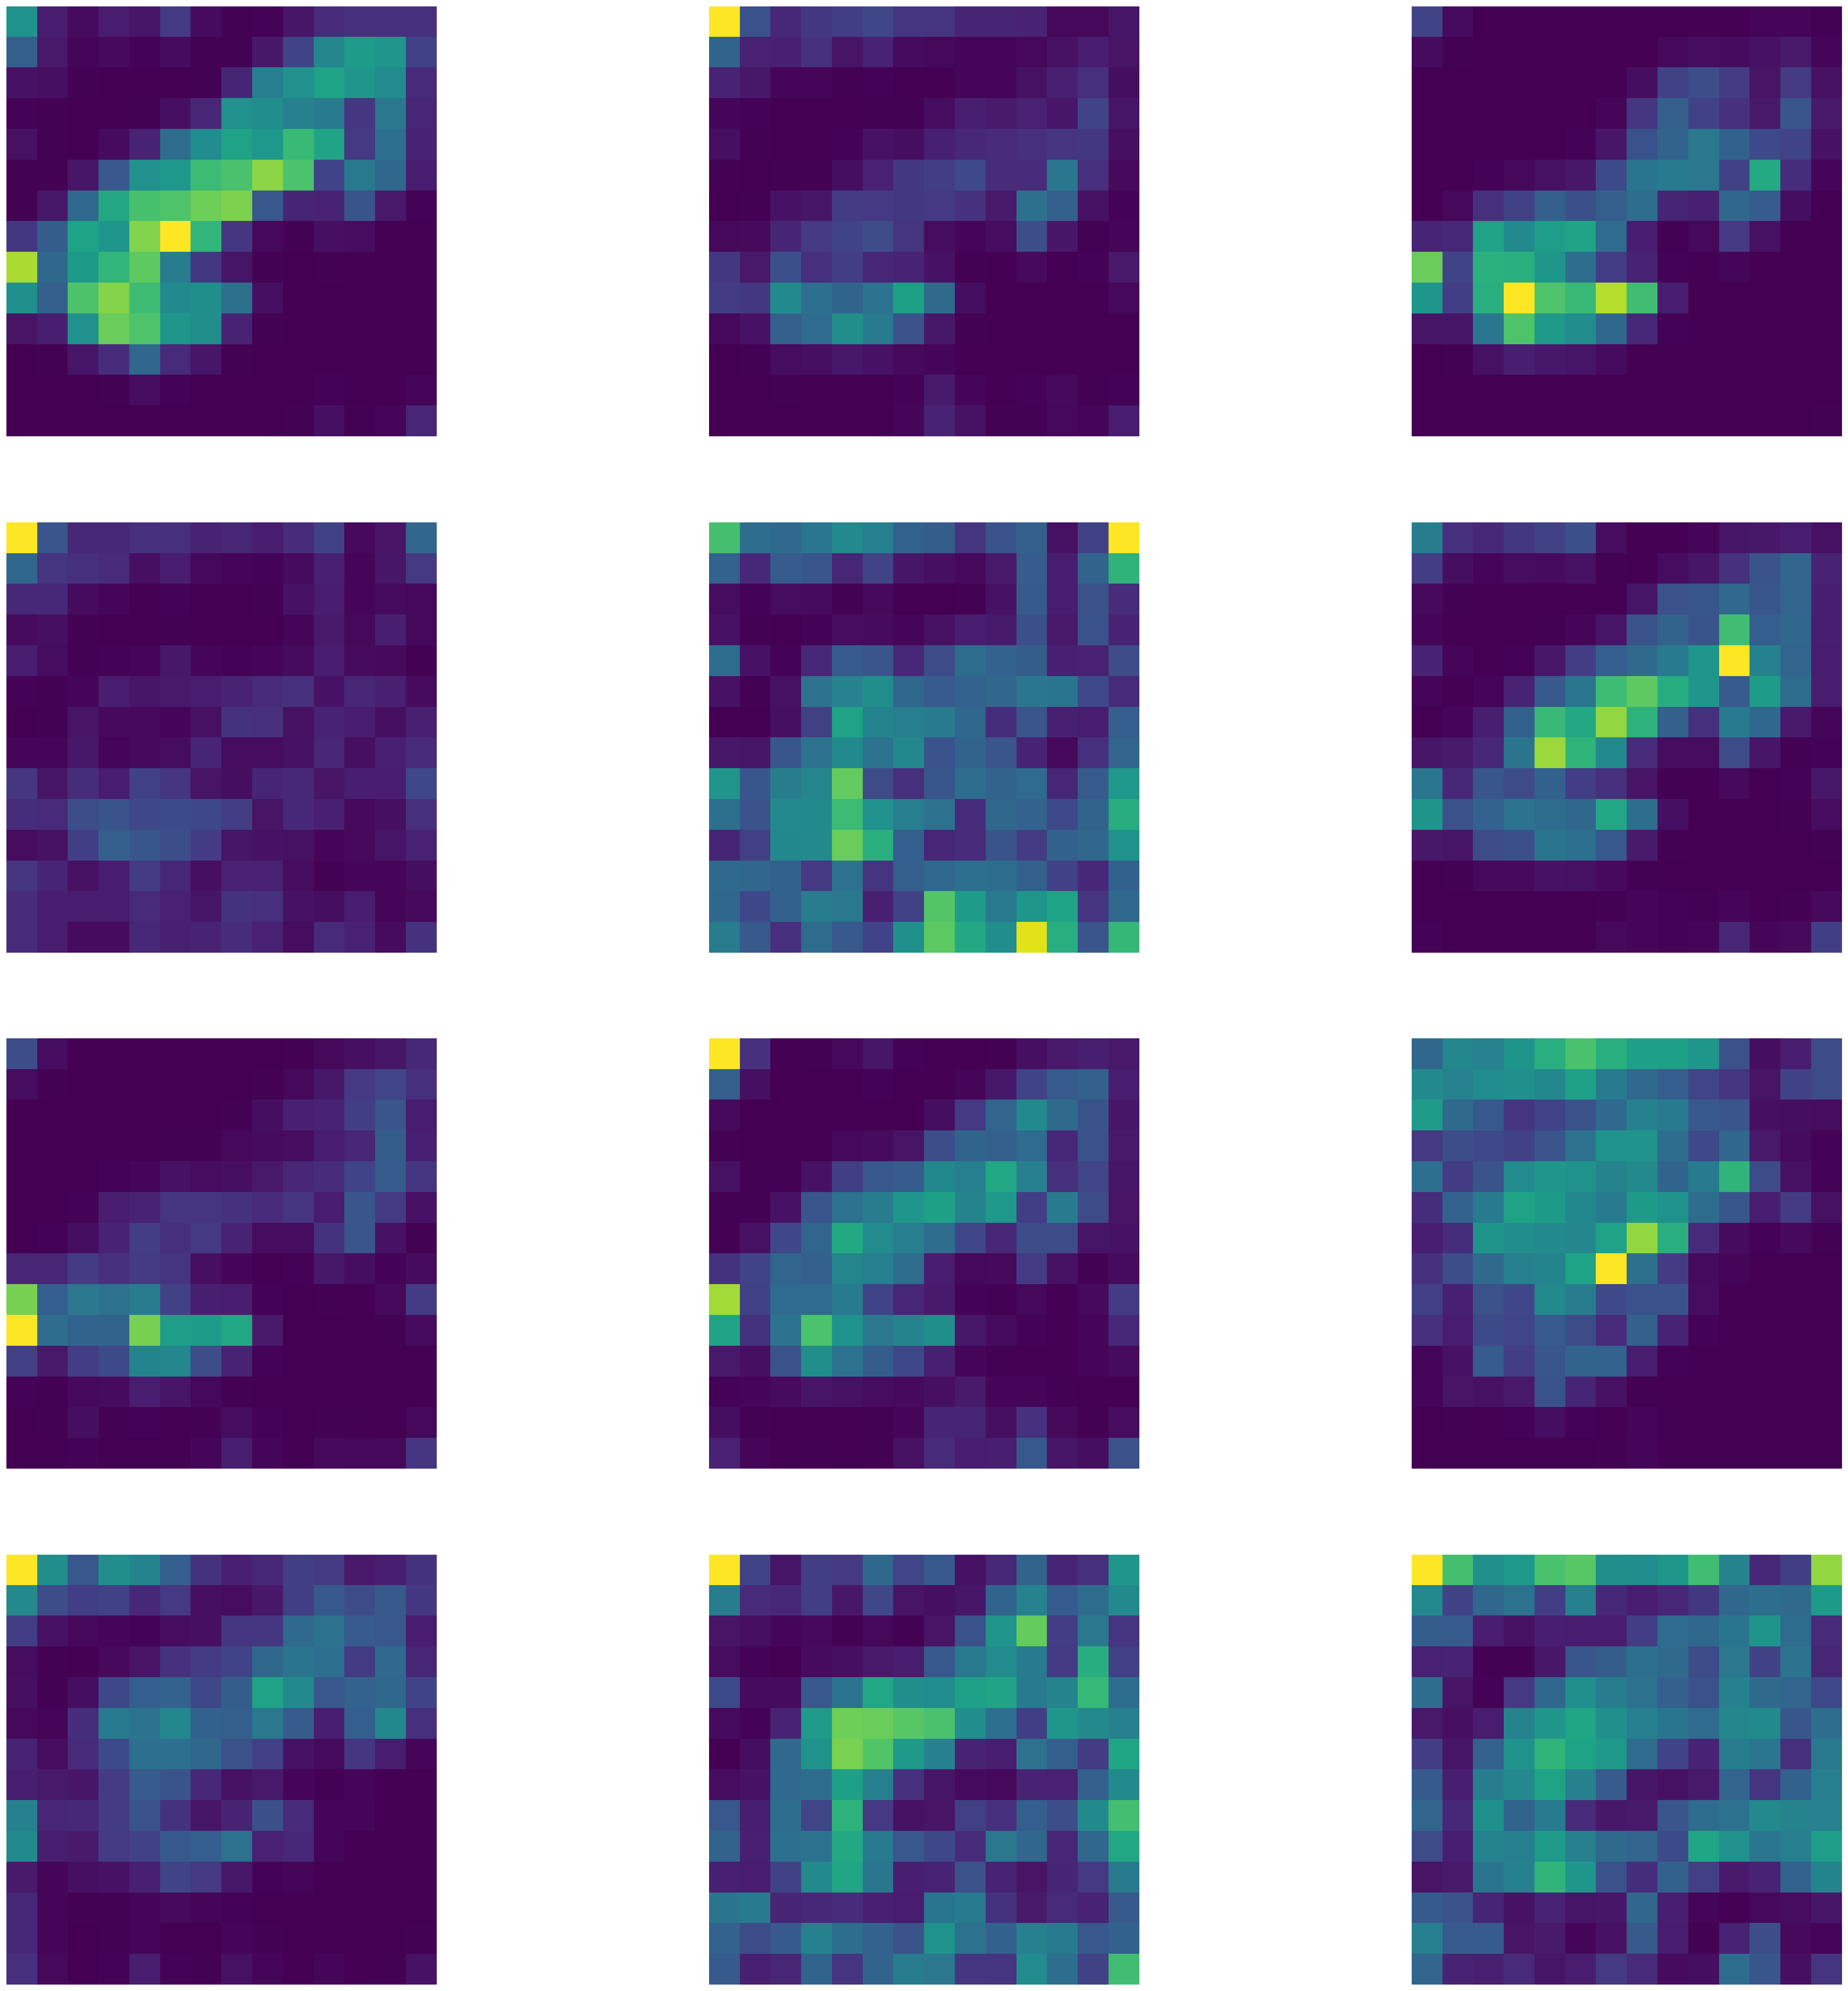

In [55]:
ig, axs = plt.subplots(4, 3, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    plotting = attn_filt.squeeze(0)
    ax.imshow(plotting[i].cpu().numpy())
    ax.axis('off')

In [56]:
# we keep only the output patch attention
attentions_last_head = attentions
print(attentions_last_head.shape)
# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions_last_head)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
print(cumval.shape)


torch.Size([12, 196])
torch.Size([12, 196])


In [57]:
w_featmap

14

In [61]:
threshold = 0.7 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]

print(th_attn.shape)

th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()

# interpolate
th_attn = torch.nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="bicubic")[0].cpu().numpy()

attentions_last_head_filtered = attentions_last_head.reshape(nh, w_featmap, h_featmap)
attentions_last_head_filtered = torch.nn.functional.interpolate(attentions_last_head_filtered.unsqueeze(0), scale_factor=patch_size, mode="bicubic")[0].cpu().numpy() * th_attn
attentions_mean = np.mean(attentions_last_head_filtered, axis=0) * th_attn.sum(axis=0)

torch.Size([12, 196])


In [62]:
data["labels"].item()

26

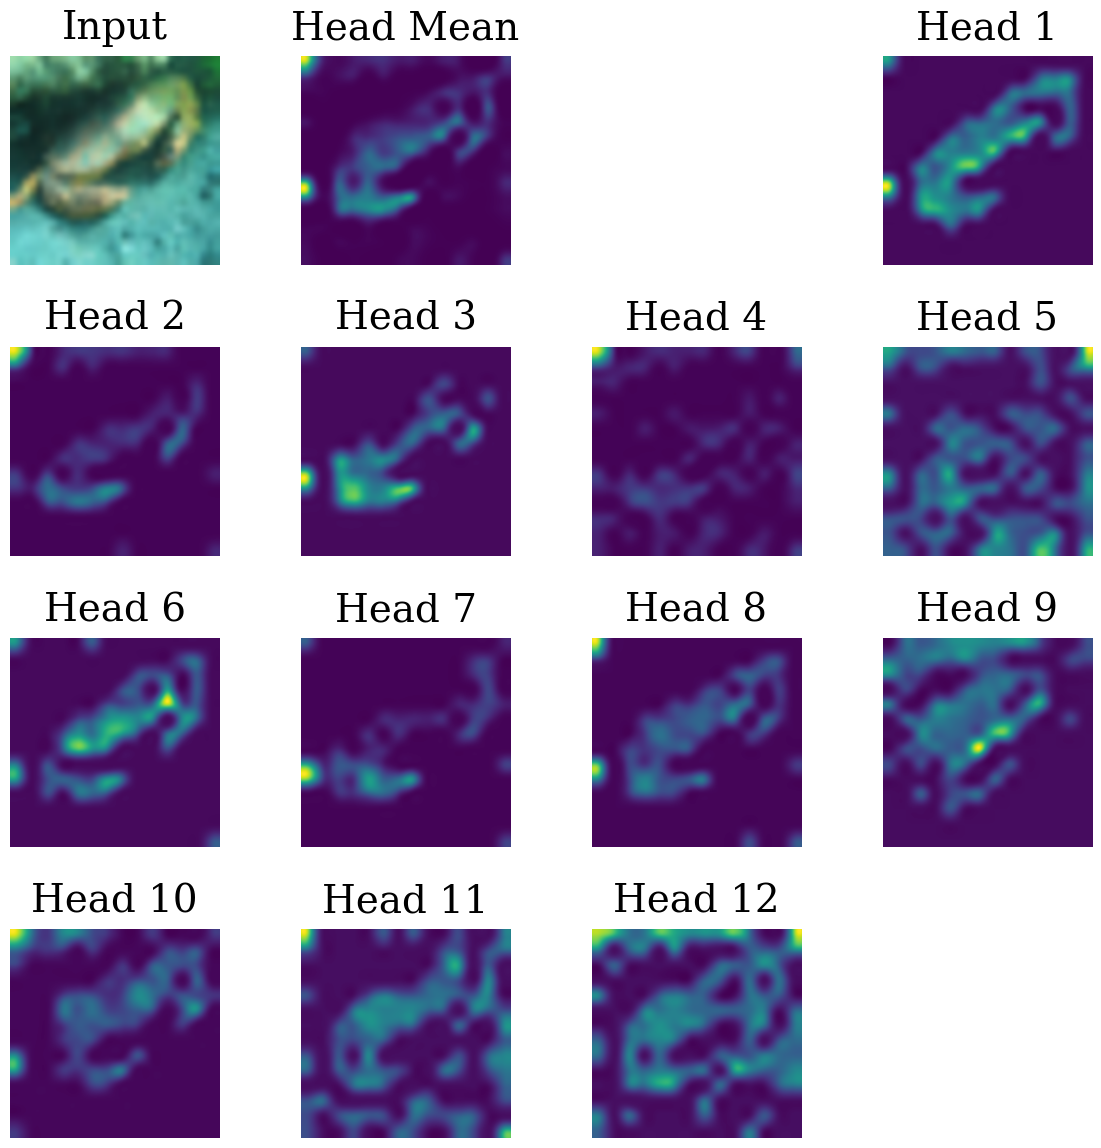

In [63]:
plt.figure(figsize=(6,6), dpi=200)
plt.subplot(4,4,1)
plt.title("Input")
plt.imshow(original_image_resized)
plt.axis("off")
# visualize self-attention of each head

for i in range(12):
    plt.subplot(4,4,i+4)
    plt.title("Head "+str(i+1))
    plt.imshow(attentions_last_head_filtered[i])
    plt.axis("off")

plt.subplot(4,4,2)
plt.title("Head Mean")
plt.imshow(attentions_mean)
plt.axis("off")
plt.tight_layout()

In [109]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import torch.nn.functional as F

def make_attention_video_thresholded_mean(
    attn_traj,
    save_path="attention_evolution_thresholded_mean.mp4",
    sample_idx=0,
    threshold=0.5,
    patch_size=16,
    w_featmap=14,
    h_featmap=14,
    fps=4,
    cmap="viridis",
):
    """
    attn_traj: list of [B, H, N, N] tensors across timesteps
    sample_idx: index of batch element to visualize
    threshold: proportion of attention mass to keep (0–1)
    patch_size: patch resolution for interpolation
    w_featmap, h_featmap: width and height of the feature map
    """

    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
    attn_videos = []

    for t_idx, attn in enumerate(attn_traj):
        # shape: [B, H, N, N]
        attentions_last_head = attn[sample_idx]  # [H, N, N]
        nh = attentions_last_head.shape[0]

        # keep only the output patch attention (typically last token)
        attentions_last_head = attentions_last_head[:, 0, 1:]  # or adjust based on your setup
        attentions_last_head = attentions_last_head.reshape(nh, -1)

        # Normalize per head
        val, idx = torch.sort(attentions_last_head)
        val = val / torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)

        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]

        # Reshape and interpolate
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        th_attn = F.interpolate(
            th_attn.unsqueeze(0), scale_factor=patch_size, mode="bicubic"
        )[0].cpu().numpy()

        # also interpolate raw attention maps
        attn_filtered = attentions_last_head.reshape(nh, w_featmap, h_featmap)
        attn_filtered = F.interpolate(
            attn_filtered.unsqueeze(0), scale_factor=patch_size, mode="bicubic"
        )[0].cpu().numpy()

        # mean attention across heads
        attentions_mean = np.mean(attn_filtered, axis=0)

        attn_videos.append(attentions_mean)

    # Create video
    vmin = np.min([m.min() for m in attn_videos])
    vmax = np.max([m.max() for m in attn_videos])

    fig, ax = plt.subplots(figsize=(5, 5))
    img = ax.imshow(attn_videos[0], cmap=cmap, vmin=vmin, vmax=vmax)
    title = ax.set_title("Time step 1", fontsize=14)
    ax.axis("off")

    writer = FFMpegWriter(fps=fps)
    with writer.saving(fig, save_path, dpi=150):
        for i, attn_mean in enumerate(attn_videos):
            img.set_data(attn_mean)
            title.set_text(f"Time step {i+1}/{len(attn_videos)}")
            writer.grab_frame()

    plt.close(fig)
    print(f"✅ Saved thresholded mean attention evolution video: {save_path}")




In [110]:
# Suppose out["attentions_per_step"] is a list of T tensors [B, H, N, N]
attn_traj = torch.stack(outputs_edo["attention_trajectory"], dim=0)
attn_traj_teacher = outputs["attentions"]
# Generate video for sample 0, head 0
make_attention_video_thresholded_mean(attn_traj, "Elefant.mp4", sample_idx=0, fps=1)


✅ Saved thresholded mean attention evolution video: Elefant.mp4


In [111]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

In [112]:
attentions = outputs_edo["attention_trajectory"]
print(torch.stack(attentions, dim=0).shape)

torch.Size([23, 1, 12, 197, 197])


In [113]:
#attentions = outputs["attentions"]
print(torch.stack(attentions, dim=0).shape)
rollout = attention_rollout(attentions)

torch.Size([23, 1, 12, 197, 197])


In [114]:
num_of_patches = 197

In [115]:
cls_attention = rollout[0, 1:, 0].detach().cpu().numpy()# Get attention values from [CLS] token to all patches
cls_attention = cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches))) #1 -

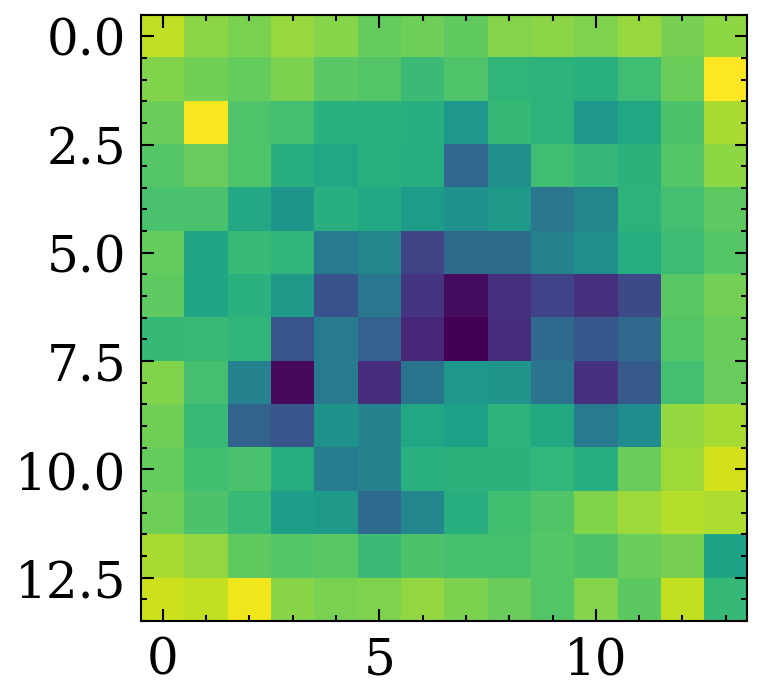

In [116]:
plt.imshow(cls_attention)

In [117]:
from PIL import Image, ImageFilter

img_size= 224
# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Resize and blur the attention map
cls_attention_resized = Image.fromarray((cls_attention * 255).astype(np.uint8)).resize((img_size, img_size), resample=Image.BICUBIC)
cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))

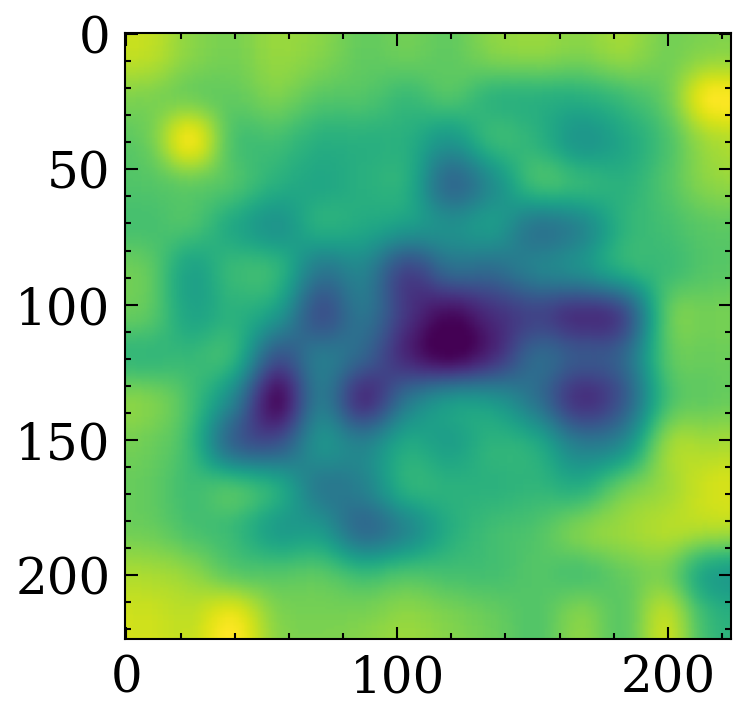

In [118]:
plt.imshow(cls_attention_resized)

In [119]:
attn = np.array(cls_attention_resized.convert("L")).astype(np.float32)
attn = attn / attn.max()  # normalize to 0–1

# --- Step 2. Create a red heatmap (you can change color easily below) ---
color = np.zeros((attn.shape[0], attn.shape[1], 4), dtype=np.uint8)
color[..., 0] = (attn * 255).astype(np.uint8)  # Red channel
color[..., 3] = (attn * 200).astype(np.uint8)  # Alpha (transparency, 0–255)

attention_overlay = Image.fromarray(color, mode="RGBA")

# --- Step 3. Resize attention map to match original image (if needed) ---
attention_overlay = attention_overlay.resize(original_image_resized.size)

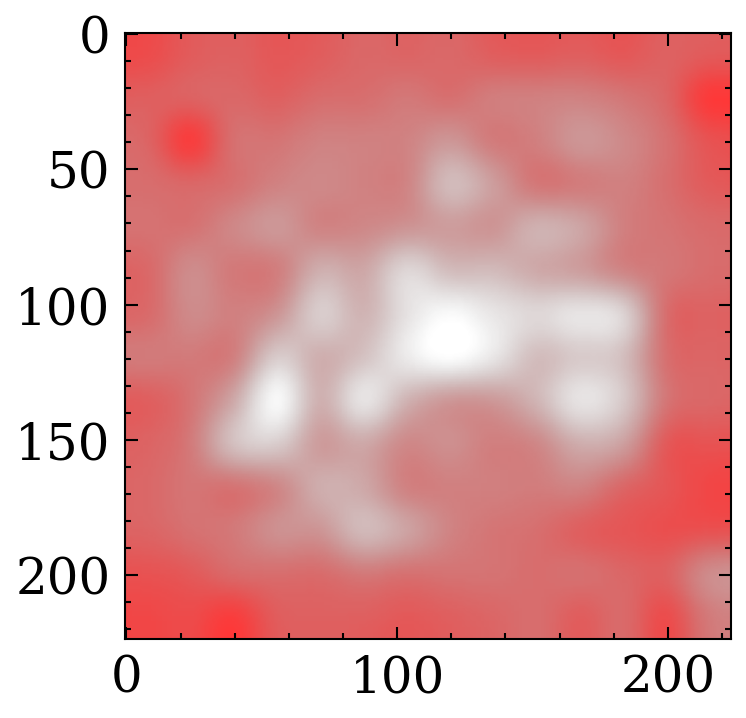

In [120]:
plt.imshow(attention_overlay)

In [121]:
blended = Image.alpha_composite(original_image_resized.convert("RGBA"), attention_overlay)

In [122]:
class_label = class_name_cif100[data["labels"].item()]

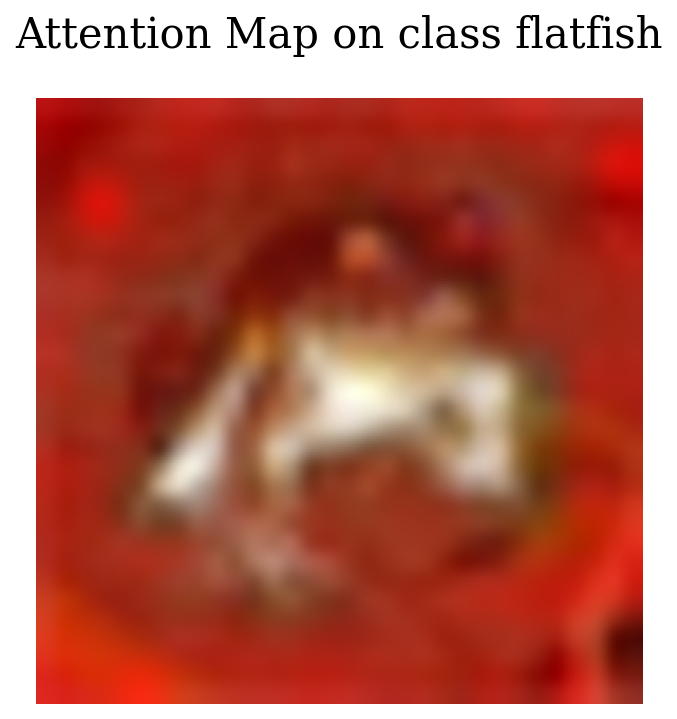

In [123]:
plt.imshow(blended)
plt.title(f"Attention Map on class {class_label}", fontsize=10, pad=12)
plt.axis("off")
plt.show()

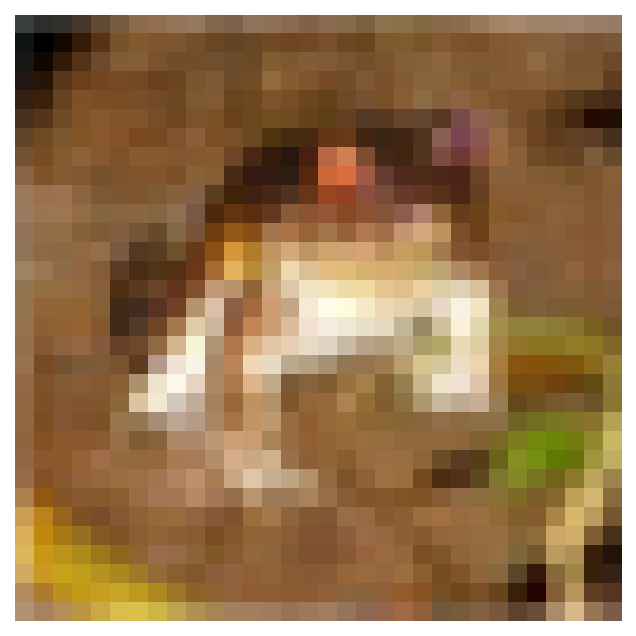

In [124]:
plt.imshow(original_image)
plt.axis("off")
plt.show()